#### Students Name and ID:
##### 1: Roy Ludan - 032736233
##### 2: Nadav Shaked - 312494925

# Recommender Systems - 2024
# *Homework 2 - Matrix Factorization*
### Due Jan 25th
### In this assignment, you will build upon your previous work and practice the implemention optimization and evaluation of RS model, based on matrix factorization. Finally, you will qualitatively evaluate your models using item similarity.

#### Instructions:

This notebook is an interactive assignment; please read and follow the instructions in each cell.

Assignments are to be turned in pairs, by one of the teammates.

Cells that require your input (in the form of code or written response) will have 'Question #' above.

Make sure the entire notebook runs without errors and includes all plots, code and explanations.

After completing the assignment, please download the notebook to an '.ipynb' file and submit it on moodle.

## Data loading and preparation for training

You may refer to your previous work for the dataset exploration part.

In [ ]:
%matplotlib inline

import dataclasses

import itertools
import os
import requests
import time
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error

sns.set()

In [ ]:
url = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
zip_name = url.split('/')[-1]
data_dir = 'ml-100k/'

r = requests.get(url, allow_redirects=True)
with open(zip_name, 'wb') as f:
    f.write(r.content)

with zipfile.ZipFile(zip_name, 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
cols_data = ['user_id', 'item_id', 'rating', 'timestamp']
cols_user = ['user_id', 'age', 'gender', 'occupation', 'zip code']
cols_item = ['movie id', 'movie_title', 'release_date', 'video_release_date',
             'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation',
             'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
             'Film_Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci_Fi',
             'Thriller', 'War', 'Western']

In [ ]:
df_users = pd.read_csv(
    os.path.join(data_dir, 'u.user'),
    delimiter='|', header=None, names=cols_user)
df_users.shape

(943, 5)

In [ ]:
df_items = pd.read_csv(
    os.path.join(data_dir, 'u.item'),
    delimiter='|', header=None, names=cols_item, encoding='ISO-8859-1')
df_items.shape

(1682, 24)

In [ ]:
df_ratings = pd.read_csv(
    os.path.join(data_dir, 'u.data'),
    delimiter='\t', header=None, names=cols_data)
df_ratings.shape

(100000, 4)

####Notes regarding the data

When building your model, keep in mind that although you fill empty entries in the rating matrix with zeros, your should handle them as missing ratings (and not as if the user gave a rating zero).

Although item and user side information is available and could be used to further optimize the models, we will focus on the rating data in this task.

In [ ]:
ratings = df_ratings.pivot(
    index='user_id', columns='item_id', values='rating').fillna(0)
ratings.head()

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def train_test_split(
    ratings: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Splits rating matrix to train and test.

    Args:
        ratings: rating matrix.

    Returns:
        Train and test matrices.
    """
    test = ratings.copy()
    test.iloc[:, :] = 0
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        non_zero_items = ratings.iloc[user, :].to_numpy().nonzero()[0]
        test_ratings = np.random.choice(
            non_zero_items, size=10, replace=False)
        train.iloc[user, test_ratings] = 0
        test.iloc[user, test_ratings] = ratings.iloc[user, test_ratings]

    # Test and training are truly disjoint.
    assert(np.all((train * test) == 0))
    return train, test
train, test = train_test_split(ratings)

train.shape, test.shape

((943, 1682), (943, 1682))

In [ ]:
# In order to see the images in the next section
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Matrix factorization model implementation

In this section, you will implement the matrix factorization model, using batch GD (gradient descent) and ALS (alternating least squares).

Consider the following objective function to be minimized by both algorithms (for simplicity, no need to add bias terms):

<img src='https://drive.google.com/uc?id=1VFtSwgAX8Y9-tQja7bqDntDizTnIg1Ko' width="500">

####GD update step:

<img src='https://drive.google.com/uc?id=1jCfjOf8nMFRM8RTcXZldWwTKPsfpoU-l' width="600">

####ALS update step:
<img src='https://drive.google.com/uc?id=14CmdzwxxaPmAEnTqBPdTWxti0MrwfcoH' width="300">

Refer to the lecture slides for the full theory.


####Quetions 1 (50 points)
Implement the follwoing MF algotihms in the designated functions using numpy and pandas only:
1. Batch GD (25 points)
2. ALS (25 points)

Notes:
* Take into account edge cases such as devision by zero, NaN, Null, Zeros, out of bound, eval time, etc.
* Use vectorized operations where possible.
* You may change the function signatures (but not required).


In [ ]:
@dataclasses.dataclass(frozen=True)
class Metrics:
  # RMSE of training set.
  rmse_train: np.float32
  # RMSE of test set.
  rmse_test: np.float32
  # MRR of test set with cutoff 5.
  mrr5_test: np.float32
  # MRR of test set with cutoff 10.
  mrr10_test: np.float32
  # Mean_NDCG of test set with cutoff 5.
  mean_ndcg5_test: np.float32
  # Mean_NDCG of test set with cutoff 10.
  mean_ndcg10_test: np.float32
  # MAP of test set with cutoff 5.
  map5_test: np.float32
  # MAP of test set with cutoff 10.
  map10_test: np.float32


class ExplicitMF:

    def __init__(
            self,
            train: pd.DataFrame,
            n_factors: int = 10,
            method: str = 'pop',
            reg: float = 1e-3,
            n_iterations: int = 20,
            learning_rate: float = 1e-3,
            eps: float = 1e-5,
    ):
        """Trains a matrix factorization model.

        Args:
          train: rating matrix.
          n_factors: number of latent factors in the matrix factorization.
          method: learning algorithm, options: 'pop', 'bias', 'gd', 'als'.
          reg: λ for user and item regularization terms.
          n_iterations: number of iterations for training.
          learning_rate: α.
          eps: stop criteria.
        """
        self.train = train
        self.n_factors = n_factors
        self.method = method
        self.reg = reg
        self.n_iterations = n_iterations
        self.learning_rate = learning_rate
        self.eps = eps
        self.n_users, self.n_items = train.shape
        self.model_params = {}
        self.progress = {}
        self.train_rmse = []
        self.test_rmse = []

    def fit_popularity(self):
        """Computes parameters in a popularity-based algorithm."""
        self.model_params['popularity'] = np.zeros(self.train.shape)
        popularity = self.model_params['popularity']
        item_avg = np.ma.masked_equal(self.train, value=0).mean(axis=0)
        item_avg[np.isnan(item_avg)] = 0
        for i in range(1, self.n_items):
            popularity[:, i] = item_avg.data[i]
        self.model_params['popularity'] = popularity
        self.train_rmse.append(self.rmse(self.train))
        self.test_rmse.append(self.rmse(test))


    def fit_bias(self):
        """Computes parameters in a bias-based algorithm."""
        mu = np.ma.masked_equal(self.train, value=0).mean()
        self.model_params['bias'] = np.full(self.train.shape, fill_value=mu)
        bias_params = self.model_params['bias']
        user_bias = np.ma.masked_equal(self.train - mu, value=-mu).mean(axis=1)
        user_bias[np.isnan(user_bias)] = 0
        item_bias = np.ma.masked_equal(self.train - mu, value=-mu).mean(axis=0)
        item_bias[np.isnan(item_bias)] = 0
        for i in range(1, self.n_users):
            for j in range(1, self.n_items):
                bias_params[i, j] = mu + user_bias.data[i] + item_bias.data[j]
        self.model_params['bias'] = bias_params
        self.train_rmse.append(self.rmse(self.train))
        self.test_rmse.append(self.rmse(test))

    def update_gd(self):
        """Computes gradient descent step."""

        U = self.model_params['U']
        V = self.model_params['V']
        R_tag = U @ V.T

        error_matrix = self.train - R_tag
        masked_error_matrix = (np.ma.masked_where(self.train == 0, error_matrix)).filled(fill_value=0)

        U_grad = masked_error_matrix @ V - self.reg * U
        self.model_params['U'] += self.learning_rate * U_grad

        V_grad = masked_error_matrix.T @ U - self.reg * V
        self.model_params['V'] += self.learning_rate * V_grad

    # Implementation for the formula above, but take in account all the items and users - give good results
    def update_als(self):
        """Computes alternating least squares step."""
        I = np.identity(self.n_factors)

        V = self.model_params['V']
        train = self.train.to_numpy()

        V_pow2 = V.T @ V
        V_pow2_with_reg = V_pow2 + self.reg * I
        V_pow2_with_reg_inv = np.linalg.inv(V_pow2_with_reg)

        rating_mul_items = train @ V

        self.model_params['U'] = rating_mul_items @ V_pow2_with_reg_inv

        U = self.model_params['U']
        U_pow2 = U.T @ U
        U_pow2_with_reg = U_pow2 + self.reg * I
        U_pow2_with_reg_inv = np.linalg.inv(U_pow2_with_reg)

        rating_mul_users = train.T @ U

        self.model_params['V'] = rating_mul_users @ U_pow2_with_reg_inv

    # Implementation for the formula above - give not good results
    def update_als_with_rated_items_only(self):
        U = self.model_params['U']
        V = self.model_params['V']

        train = self.train.to_numpy()
        users_count = train.shape[0]
        items_count = train.shape[1]

        I = np.identity(self.n_factors)
        reg_vec = self.reg * I

        for i in range(users_count):
            V_pow2 = np.zeros([self.n_factors, self.n_factors])
            ratings_items_acc = np.zeros([1, self.n_factors])

            for j in range(items_count):
                if train[i, j] > 0:
                    V_j = V[j, :].reshape(1, -1)
                    V_pow2 += V_j.T @ V_j
                    ratings_items_acc += train[i, j] * V_j

            V_pow2_acc = V_pow2 + reg_vec

            self.model_params['U'][i, :] = ratings_items_acc @ np.linalg.inv(V_pow2_acc)

        U = self.model_params['U']
        for j in range(items_count):
            U_pow2 = np.zeros([self.n_factors, self.n_factors])
            rating_users_acc = np.zeros([1, self.n_factors])

            for i in range(users_count):
                if train[i, j] > 0:
                    U_i = U[i, :].reshape(1, -1)
                    U_pow2 += U_i.T @ U_i
                    rating_users_acc += train[i, j] * U_i

            U_pow2_acc = U_pow2 + reg_vec

            self.model_params['V'][j, :] = rating_users_acc @ np.linalg.inv(U_pow2_acc)

    def training(self, test: pd.DataFrame):
        """Main method for training all algorithms.

        Args:
            test: test rating matrix.
        """
        if self.method == 'pop':
            self.fit_popularity()
            return

        if self.method == 'bias':
            self.fit_bias()
            return

        # Initialize latent vectors.
        self.model_params['U'] = np.random.randn(
            self.n_users, self.n_factors) * 0.01
        self.model_params['V'] = np.random.randn(
            self.n_items, self.n_factors) * 0.01

        for i in range(self.n_iterations):
            if i % 10 == 0:
                print('\tcurrent iteration: {}'.format(i))
            if self.method == 'als':
                self.update_als()
            elif self.method == 'gd':
                self.update_gd()

            self.train_rmse.append(self.rmse(self.train))
            self.test_rmse.append(self.rmse(test))
            # Don't break in the first iteration.
            if not i:
                continue

            if self.eps > abs(self.train_rmse[i] - self.train_rmse[i-1]):
                break

    def recommnd_unseen(self, user: int, n_items: int) -> list:
        """Recommends unseen items per user, oredered by predicted ratings desc.

        Args:
          user: user id.
          n_items: number of items to suggest.

        Returns:
          Top suggestions.
        """
        if self.method == 'pop':
            predicted_ratings = self.model_params['popularity'][user]
        elif self.method == 'bias':
            predicted_ratings = self.model_params['bias'][user]
        else:
            user_vec = self.model_params['U'][user, :]
            predicted_ratings = user_vec @ self.model_params['V'].T


        pred_sorted = np.argsort(predicted_ratings)[::-1]
        unseen_movie = np.where(self.train.iloc[user] == 0)
        final = pred_sorted[np.in1d(pred_sorted, unseen_movie)]
        return final[:n_items]

    def predict(self, user: int, item: int) -> float:
        """Predicts the rating of a specific item for a specific user.

        Args:
          user: user id.
          item: item id.

        Returns:
          Predicted rating.
        """
        if self.method == 'pop':
            return self.model_params['popularity'][user, item]

        if self.method == 'bias' :
            return  self.model_params['bias'][user, item]

        user_vec = self.model_params['U'][user, :]
        item_vec = self.model_params['V'][item, :]
        return np.dot(user_vec, item_vec)

    def predict_all(self):
        """Predicts ratings for every user and item.

        Args: None

        Returns:
            All predicted ratings
        """
        predictions = np.zeros(shape=(self.n_users, self.n_items))
        for u in range(self.n_users):
            for i in range(self.n_items):
                predictions[u, i] = self.predict(u, i)
        return predictions

    def rmse(self, actual: pd.DataFrame) -> float:
        """Computes the total RMSE of a model, compared to the actual rating.

        Args:
          actual: actual rating matrix.

        Returns:
          Total RMSE.
        """
        preds = self.predict_all()
        preds = preds[actual > 0].flatten()
        actual = actual.to_numpy()
        actual_non_zeros = actual[actual > 0].flatten()
        rmse = np.sqrt(np.mean(actual_non_zeros - preds)**2)
        return rmse


    def mrr(self, test: pd.DataFrame, k: int = 5) -> float:
        """Computes the Mean Reciprocal Rank for all users.

        Note: relevancy is considered rating 3 or above.

        Args:
          test: rating matrix.
          k: cutoff value.

        Returns:
          MRR.
        """
        mrr = 0
        for user in range(self.n_users):
            list_pred = self.recommnd_unseen(user, k)
            user_test = test.iloc[user]
            actual = user_test[user_test >= 3]
            for j in range(k):
                if list_pred[j] in actual:
                    mrr += 1 / (j + 1)
        return mrr / self.n_users

    def dcg(self, user: int, test: pd.DataFrame, k: int = 5) -> float:
        """Computes the Discounted Cumulative Gain for a given user.

        Args:
            user: user id.
            test: rating matrix.
            k: cutoff value.

        Returns:
            DCG.
        """
        rank_pred = self.recommnd_unseen(user, k)
        user_test = test.iloc[user]
        actual = user_test[user_test >= 0]

        dcg = 0
        for j in range(k):
            if rank_pred[j] in actual:
                rating = user_test.iloc[rank_pred[j]]
                m = rating / np.log2(j + 2)
                dcg += m
        return dcg

    def idcg(self, user: int, test: pd.DataFrame, k: int = 5) -> float:
        """Computes the Idealized Discounted Cumulative Gain for a given user.

        Args:
            user: user id.
            test: rating matrix.
            k: cutoff value.

        Returns:
            iDCG.
        """
        rank_pred = self.recommnd_unseen(user, k)
        user_test = test.iloc[user]
        actual = user_test[user_test >= 0]
        true_rating = actual.iloc[rank_pred]
        true_sort = true_rating.sort_values(ascending=False)
        idcg = 0
        for i in range(len(true_sort)):
            m = true_sort.iloc[i] / np.log2(i + 2)
            idcg += m
        return idcg

    def mean_ndcg(self, test: pd.DataFrame, k: int = 5) -> float:
        """Computes Mean Normalized Discounted Cumulative Gain for all users.

        Args:
          test: rating matrix.
          k: cutoff value.

        Returns:
          Mean nDCG.
        """
        ndcg = 0
        for user in range(self.n_users):
            dcg = self.dcg(user, test, k)
            idcg = self.idcg(user, test, k)
            if idcg > 0:
                m = dcg / idcg
            else:
                m = 0
            ndcg += m
        return ndcg / self.n_users

    def map(self, test: pd.DataFrame, k: int = 5) -> float:
        """Computes the mean average precision for all users.

        Note: relevancy is considered rating 3 or above.

        Args:
          test: rating matrix.
          k: cutoff value.

        Returns:
          Overall MAP.
        """
        ap_list = []
        for user in range(self.n_users):
            list_pred = self.recommnd_unseen(user, k)
            user_test = test.iloc[user]
            actual = user_test[user_test >= 3]
            ap = []
            hits = 0
            for j in range(k):
                if list_pred[j] in actual:
                    hits += 1
                    ap.append(hits / (j + 1))
            if ap:
                ap_list.append(np.mean(ap))
            else:
                ap_list.append(0)
        map = np.mean(ap_list)
        return map

    def get_all_metrics(self, test: pd.DataFrame) -> Metrics:
      """Gets all metrics of the trained model.

      Args:
        test: rating matrix.

      Returns:
        Metrics object.
      """
      return Metrics(
          rmse_train=self.rmse(self.train),
          rmse_test=self.rmse(test),
          mrr5_test=self.mrr(test, 5),
          mrr10_test=self.mrr(test, 10),
          mean_ndcg5_test=self.mean_ndcg(test, 5),
          mean_ndcg10_test=self.mean_ndcg(test, 10),
          map5_test=self.map(test, 5),
          map10_test=self.map(test, 10))


In [ ]:
def plot_learning_curve(model: ExplicitMF):
    """Plots learning curve.

    Args:
        model: trained RS model.
    """
    plt.plot(model.train_rmse, label='Training', linewidth=5)
    plt.plot(model.test_rmse, label='Test', linewidth=5)
    plt.xlabel('iterations');
    plt.ylabel('RMSE');
    plt.legend(loc='best');

###Train all models with the default parameters

In [ ]:
    results = []

Popularity model

In [ ]:
    method = 'pop'
    pop = ExplicitMF(train, method=method)
    start_time = time.time()
    pop.training(test)
    training_time = time.time() - start_time
    print('--- %s seconds ---' % (training_time))
    metrics = pop.get_all_metrics(test)
    results.append(
        [method] + list(dataclasses.astuple(metrics)) + [training_time])

--- 6.243155002593994 seconds ---


Bias model

In [ ]:
    method = 'bias'
    bias = ExplicitMF(train, method=method)
    start_time = time.time()
    bias.training(test)
    training_time = time.time() - start_time
    print('--- %s seconds ---' % (training_time))
    metrics = bias.get_all_metrics(test)
    results.append(
        [method] + list(dataclasses.astuple(metrics)) + [training_time])

--- 3.4729228019714355 seconds ---


Gradient descent model

	current iteration: 0
	current iteration: 10
--- 181.39775776863098 seconds ---


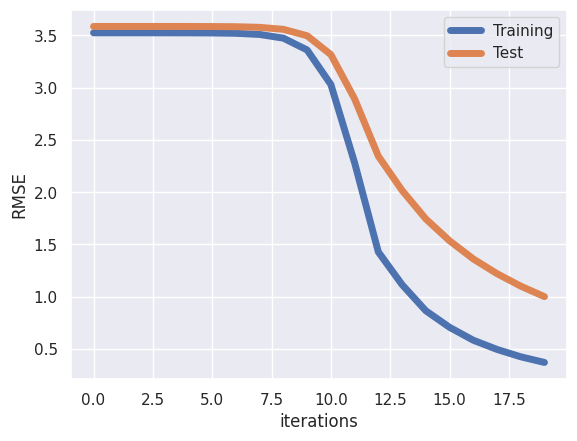

In [ ]:
    method = 'gd'
    gd = ExplicitMF(train, method=method)
    start_time = time.time()
    gd.training(test)
    training_time = time.time() - start_time
    print('--- %s seconds ---' % (training_time))
    metrics = gd.get_all_metrics(test)
    results.append(
        [method] + list(dataclasses.astuple(metrics)) + [training_time])
    plot_learning_curve(gd)

ALS model

	current iteration: 0
	current iteration: 10
--- 136.77579021453857 seconds ---


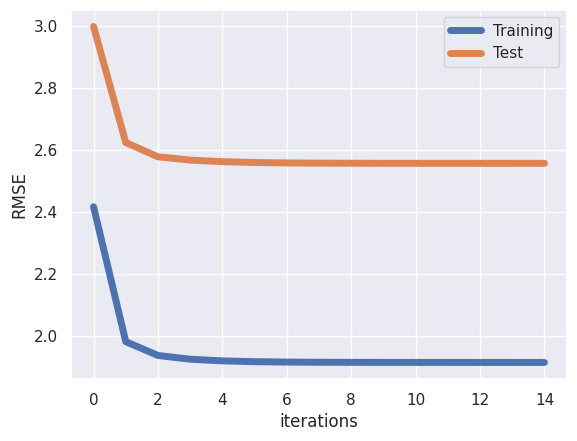

In [ ]:
    method = 'als'
    als = ExplicitMF(train, method=method)
    start_time = time.time()
    als.training(test)
    training_time = time.time() - start_time
    print('--- %s seconds ---' % (training_time))
    metrics = als.get_all_metrics(test)
    results.append(
        [method] + list(dataclasses.astuple(metrics)) + [training_time])
    plot_learning_curve(als)

Compare of the different models using various metrics

In [ ]:
columns = ['RMSE training', 'RMSE test', 'MRR k=5 test', 'MRR k=10 test',
           'Mean NDCG k=5 test', 'Mean NDCG k=10 test', 'MAP k=5 test',
           'MAP k=10 test', 'Training time']

def results_to_pd(results: list) -> pd.DataFrame:
    """Prepares results for table.

    Args:
        results: results list.

    Returns:
        Results table.
    """
    results_pd = pd.DataFrame(results).set_index(0)
    results_pd = results_pd.set_index(results_pd.index.rename('Model / Metric'))
    results_pd.columns = columns
    return results_pd

lower_better = ['RMSE training', 'RMSE test', 'Training time']
higher_better = list(set(columns) - set(lower_better))

In [ ]:
results_pd = results_to_pd(results)

In [ ]:
results_pd.style.background_gradient(
    'RdYlGn_r', axis=0, subset=lower_better
).background_gradient('RdYlGn', axis=0, subset=higher_better)

,RMSE training,RMSE test,MRR k=5 test,MRR k=10 test,Mean NDCG k=5 test,Mean NDCG k=10 test,MAP k=5 test,MAP k=10 test,Training time
Model / Metric,,,,,,,,,
pop,2.945142,2.953382,0.024708,0.030475,0.314206,0.369220,0.023206,0.028557,6.243155
bias,2.736662,2.952546,0.024708,0.030475,0.313749,0.368491,0.023206,0.028557,3.472923
gd,0.371258,1.000717,0.041375,0.049384,0.190115,0.224997,0.041375,0.049012,181.397758
als,1.914690,2.556994,0.058625,0.076692,0.589683,0.601269,0.057432,0.068826,136.775790


### Hyperparameter tuning - ALS
Now that we have trained our models with the default hyperparameters, it's time to find their optimal values using grid search.

Factors: 5
iterations: 25
regularization: 0.001
	current iteration: 0
	current iteration: 10
	current iteration: 20
New optimal hyperparameters
n_factors                                                  5
reg                                                    0.001
n_iter                                                    25
train_rmse                                          2.092821
test_rmse                                           2.659249
model         <__main__.ExplicitMF object at 0x7e6d2c6cd7e0>
dtype: object
--- 226.45607829093933 seconds ---
Factors: 5
iterations: 25
regularization: 0.01
	current iteration: 0
	current iteration: 10
Factors: 5
iterations: 25
regularization: 0.1
	current iteration: 0
	current iteration: 10
Factors: 10
iterations: 25
regularization: 0.001
	current iteration: 0
	current iteration: 10
	current iteration: 20
New optimal hyperparameters
n_factors                                                 10
reg                                                 

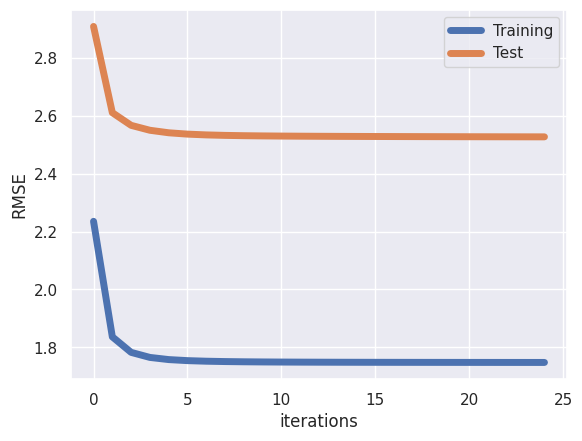

In [ ]:
latent_factors = [5, 10, 20, 25]
regularizations = [0.001, 0.01, 0.1]
iter_array = [25]

best_params = {}
best_params['n_factors'] = latent_factors[0]
best_params['reg'] = regularizations[0]
best_params['n_iter'] = iter_array[0]
best_params['train_rmse'] = np.inf
best_params['test_rmse'] = np.inf
best_params['model'] = None

for fact, n_iter, reg in itertools.product(
    latent_factors, iter_array, regularizations):
    print('Factors: {}'.format(fact))
    print('iterations: {}'.format(n_iter))
    print('regularization: {}'.format(reg))

    method = 'als'
    model_name = ''.join([
        method,
        '_fact_', str(fact),
        '_reg_', str(reg),
        '_iter_', str(n_iter)])
    als_grid = ExplicitMF(
        train, method=method, n_factors=fact, n_iterations=n_iter, reg=reg)
    start_time = time.time()
    als_grid.training(test)
    training_time = time.time() - start_time
    min_idx = np.argmin(als_grid.test_rmse)
    if als_grid.test_rmse[min_idx] >= best_params['test_rmse']:
        continue

    metrics = als_grid.get_all_metrics(test)
    results.append(
        [model_name] + list(dataclasses.astuple(metrics)) + [training_time])
    best_params['n_factors'] = fact
    best_params['reg'] = reg
    best_params['n_iter'] = n_iter
    best_params['train_rmse'] = als_grid.train_rmse[min_idx]
    best_params['test_rmse'] = als_grid.test_rmse[min_idx]
    best_params['model'] = als_grid
    print('New optimal hyperparameters')
    print(pd.Series(best_params))
    print('--- %s seconds ---' % (training_time))

best_als_model = best_params['model']
plot_learning_curve(best_als_model)

In [ ]:
results_pd = results_to_pd(results)

In [ ]:
results_pd.style.background_gradient(
    'RdYlGn_r', axis=0, subset=lower_better
).background_gradient('RdYlGn', axis=0, subset=higher_better)

,RMSE training,RMSE test,MRR k=5 test,MRR k=10 test,Mean NDCG k=5 test,Mean NDCG k=10 test,MAP k=5 test,MAP k=10 test,Training time
Model / Metric,,,,,,,,,
pop,2.945142,2.953382,0.024708,0.030475,0.314206,0.369220,0.023206,0.028557,6.243155
bias,2.736662,2.952546,0.024708,0.030475,0.313749,0.368491,0.023206,0.028557,3.472923
gd,0.371258,1.000717,0.041375,0.049384,0.190115,0.224997,0.041375,0.049012,181.397758
als,1.914690,2.556994,0.058625,0.076692,0.589683,0.601269,0.057432,0.068826,136.775790
als_fact_5_reg_0.001_iter_25,2.092618,2.672822,0.062372,0.076007,0.553577,0.563467,0.061577,0.070376,226.456078
als_fact_10_reg_0.001_iter_25,1.914747,2.557230,0.056186,0.074735,0.591119,0.601574,0.054993,0.067351,207.123170
als_fact_10_reg_0.1_iter_25,1.914774,2.556583,0.058872,0.075986,0.592586,0.601820,0.057414,0.068951,224.039754
als_fact_20_reg_0.001_iter_25,1.747101,2.527355,0.057370,0.077122,0.621030,0.632492,0.056354,0.068145,224.407036


####Quetions 2 (10 points)

If there are any hyperparameters that could be further tuned (for example, if the best value for a hyperparameter is at the maximun of the grid scale), expand the grid search and continue the exploration. Make sure all your experiments are documented in the results table.

Which are the best hyperparameters for the ALS model?

Discuss your observations (overfitting, etc.)



After our initial exploration with default hyperparameters, we identified that the ALS (Alternating Least Squares) algorithm demonstrated optimal performance with specific configurations: n_factors = 20, reg = 0.001, and iteration = 25. Recognizing the possibility for further improvement, we decided to extend the grid search, particularly focusing on the n_factors hyperparameter.

In our expanded grid search, we systematically varied the n_factors values, seeking to identify the optimal setting. After experimenting with an increased n_factors to 25, we observed a notable improvement in results. The refined set of hyperparameters that produced the best outcomes was determined to be n_factors = 25, reg = 0.01, and iteration = 25.

This adjustment demonstrated improved performance, and ongoing vigilance for overfitting is recommended as the model complexity increases. The results of these experiments have been documented in the results table for further reference.

### Hyperparameter tuning - GD


####Quetions 3 (15 points)
Repeat the process of grid search for the gradient descent model.
Don't forget to include also learning rate optimization. Make sure all your experiments are documented in the results table.


Factors: 5
iterations: 25
regularization: 0.001
learning_rate: 0.01
	current iteration: 0


<ipython-input-10-36ce2cecfb4e>:276: RuntimeWarning: overflow encountered in double_scalars
  rmse = np.sqrt(np.mean(actual_non_zeros - preds)**2)
<ipython-input-10-36ce2cecfb4e>:96: RuntimeWarning: overflow encountered in matmul
  U_grad = masked_error_matrix @ V - self.reg * U
<ipython-input-10-36ce2cecfb4e>:99: RuntimeWarning: invalid value encountered in matmul
  V_grad = masked_error_matrix.T @ U - self.reg * V


	current iteration: 10
	current iteration: 20
New optimal hyperparameters
n_factors                                                     5
reg                                                       0.001
n_iter                                                       25
learning_rate                             [0.01, 0.001, 0.0001]
train_rmse                                                  NaN
test_rmse                                                   NaN
model            <__main__.ExplicitMF object at 0x7e6d2c682fe0>
dtype: object
--- 224.96819186210632 seconds ---
Factors: 5
iterations: 25
regularization: 0.001
learning_rate: 0.001
	current iteration: 0
New optimal hyperparameters
n_factors                                                     5
reg                                                       0.001
n_iter                                                       25
learning_rate                             [0.01, 0.001, 0.0001]
train_rmse                                            

<ipython-input-10-36ce2cecfb4e>:276: RuntimeWarning: overflow encountered in double_scalars
  rmse = np.sqrt(np.mean(actual_non_zeros - preds)**2)
<ipython-input-10-36ce2cecfb4e>:99: RuntimeWarning: overflow encountered in matmul
  V_grad = masked_error_matrix.T @ U - self.reg * V
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
<ipython-input-10-36ce2cecfb4e>:96: RuntimeWarning: invalid value encountered in matmul
  U_grad = masked_error_matrix @ V - self.reg * U


	current iteration: 10
	current iteration: 20
New optimal hyperparameters
n_factors                                                     5
reg                                                        0.01
n_iter                                                       25
learning_rate                             [0.01, 0.001, 0.0001]
train_rmse                                                  NaN
test_rmse                                                   NaN
model            <__main__.ExplicitMF object at 0x7e6d2c6830d0>
dtype: object
--- 224.29067969322205 seconds ---
Factors: 5
iterations: 25
regularization: 0.01
learning_rate: 0.001
	current iteration: 0
New optimal hyperparameters
n_factors                                                     5
reg                                                        0.01
n_iter                                                       25
learning_rate                             [0.01, 0.001, 0.0001]
train_rmse                                             

<ipython-input-10-36ce2cecfb4e>:276: RuntimeWarning: overflow encountered in double_scalars
  rmse = np.sqrt(np.mean(actual_non_zeros - preds)**2)
<ipython-input-10-36ce2cecfb4e>:96: RuntimeWarning: overflow encountered in matmul
  U_grad = masked_error_matrix @ V - self.reg * U
<ipython-input-10-36ce2cecfb4e>:99: RuntimeWarning: invalid value encountered in matmul
  V_grad = masked_error_matrix.T @ U - self.reg * V


	current iteration: 10
	current iteration: 20
New optimal hyperparameters
n_factors                                                     5
reg                                                         0.1
n_iter                                                       25
learning_rate                             [0.01, 0.001, 0.0001]
train_rmse                                                  NaN
test_rmse                                                   NaN
model            <__main__.ExplicitMF object at 0x7e6d2c682a10>
dtype: object
--- 224.80131030082703 seconds ---
Factors: 5
iterations: 25
regularization: 0.1
learning_rate: 0.001
	current iteration: 0
New optimal hyperparameters
n_factors                                                     5
reg                                                         0.1
n_iter                                                       25
learning_rate                             [0.01, 0.001, 0.0001]
train_rmse                                             3

<ipython-input-10-36ce2cecfb4e>:276: RuntimeWarning: overflow encountered in double_scalars
  rmse = np.sqrt(np.mean(actual_non_zeros - preds)**2)
<ipython-input-10-36ce2cecfb4e>:96: RuntimeWarning: overflow encountered in matmul
  U_grad = masked_error_matrix @ V - self.reg * U
<ipython-input-10-36ce2cecfb4e>:99: RuntimeWarning: invalid value encountered in matmul
  V_grad = masked_error_matrix.T @ U - self.reg * V


	current iteration: 10
	current iteration: 20
New optimal hyperparameters
n_factors                                                    10
reg                                                       0.001
n_iter                                                       25
learning_rate                             [0.01, 0.001, 0.0001]
train_rmse                                                  NaN
test_rmse                                                   NaN
model            <__main__.ExplicitMF object at 0x7e6d2c682a70>
dtype: object
--- 225.01866483688354 seconds ---
Factors: 10
iterations: 25
regularization: 0.001
learning_rate: 0.001
	current iteration: 0
	current iteration: 10
	current iteration: 20
New optimal hyperparameters
n_factors                                                    10
reg                                                       0.001
n_iter                                                       25
learning_rate                             [0.01, 0.001, 0.0001]
train_r

<ipython-input-10-36ce2cecfb4e>:276: RuntimeWarning: overflow encountered in double_scalars
  rmse = np.sqrt(np.mean(actual_non_zeros - preds)**2)
<ipython-input-10-36ce2cecfb4e>:96: RuntimeWarning: overflow encountered in matmul
  U_grad = masked_error_matrix @ V - self.reg * U
<ipython-input-10-36ce2cecfb4e>:99: RuntimeWarning: invalid value encountered in matmul
  V_grad = masked_error_matrix.T @ U - self.reg * V


	current iteration: 10
	current iteration: 20
New optimal hyperparameters
n_factors                                                    10
reg                                                        0.01
n_iter                                                       25
learning_rate                             [0.01, 0.001, 0.0001]
train_rmse                                                  NaN
test_rmse                                                   NaN
model            <__main__.ExplicitMF object at 0x7e6d2c682a40>
dtype: object
--- 228.08363127708435 seconds ---
Factors: 10
iterations: 25
regularization: 0.01
learning_rate: 0.001
	current iteration: 0
New optimal hyperparameters
n_factors                                                    10
reg                                                        0.01
n_iter                                                       25
learning_rate                             [0.01, 0.001, 0.0001]
train_rmse                                            

<ipython-input-10-36ce2cecfb4e>:276: RuntimeWarning: overflow encountered in double_scalars
  rmse = np.sqrt(np.mean(actual_non_zeros - preds)**2)
<ipython-input-10-36ce2cecfb4e>:96: RuntimeWarning: overflow encountered in matmul
  U_grad = masked_error_matrix @ V - self.reg * U
<ipython-input-10-36ce2cecfb4e>:99: RuntimeWarning: invalid value encountered in matmul
  V_grad = masked_error_matrix.T @ U - self.reg * V


	current iteration: 10
	current iteration: 20
New optimal hyperparameters
n_factors                                                    10
reg                                                         0.1
n_iter                                                       25
learning_rate                             [0.01, 0.001, 0.0001]
train_rmse                                                  NaN
test_rmse                                                   NaN
model            <__main__.ExplicitMF object at 0x7e6d2c682920>
dtype: object
--- 224.7789876461029 seconds ---
Factors: 10
iterations: 25
regularization: 0.1
learning_rate: 0.001
	current iteration: 0
	current iteration: 10
	current iteration: 20
New optimal hyperparameters
n_factors                                                    10
reg                                                         0.1
n_iter                                                       25
learning_rate                             [0.01, 0.001, 0.0001]
train_rmse

<ipython-input-10-36ce2cecfb4e>:276: RuntimeWarning: overflow encountered in double_scalars
  rmse = np.sqrt(np.mean(actual_non_zeros - preds)**2)
<ipython-input-10-36ce2cecfb4e>:96: RuntimeWarning: overflow encountered in matmul
  U_grad = masked_error_matrix @ V - self.reg * U
<ipython-input-10-36ce2cecfb4e>:99: RuntimeWarning: invalid value encountered in matmul
  V_grad = masked_error_matrix.T @ U - self.reg * V


	current iteration: 10
	current iteration: 20
New optimal hyperparameters
n_factors                                                    20
reg                                                       0.001
n_iter                                                       25
learning_rate                             [0.01, 0.001, 0.0001]
train_rmse                                                  NaN
test_rmse                                                   NaN
model            <__main__.ExplicitMF object at 0x7e6d2c682d40>
dtype: object
--- 231.9799361228943 seconds ---
Factors: 20
iterations: 25
regularization: 0.001
learning_rate: 0.001
	current iteration: 0
	current iteration: 10
	current iteration: 20
New optimal hyperparameters
n_factors                                                    20
reg                                                       0.001
n_iter                                                       25
learning_rate                             [0.01, 0.001, 0.0001]
train_rm

<ipython-input-10-36ce2cecfb4e>:276: RuntimeWarning: overflow encountered in double_scalars
  rmse = np.sqrt(np.mean(actual_non_zeros - preds)**2)
<ipython-input-10-36ce2cecfb4e>:99: RuntimeWarning: overflow encountered in matmul
  V_grad = masked_error_matrix.T @ U - self.reg * V
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
<ipython-input-10-36ce2cecfb4e>:96: RuntimeWarning: invalid value encountered in matmul
  U_grad = masked_error_matrix @ V - self.reg * U


	current iteration: 10
	current iteration: 20
New optimal hyperparameters
n_factors                                                    20
reg                                                        0.01
n_iter                                                       25
learning_rate                             [0.01, 0.001, 0.0001]
train_rmse                                                  NaN
test_rmse                                                   NaN
model            <__main__.ExplicitMF object at 0x7e6d2c682b30>
dtype: object
--- 225.71321940422058 seconds ---
Factors: 20
iterations: 25
regularization: 0.01
learning_rate: 0.001
	current iteration: 0
	current iteration: 10
	current iteration: 20
New optimal hyperparameters
n_factors                                                    20
reg                                                        0.01
n_iter                                                       25
learning_rate                             [0.01, 0.001, 0.0001]
train_rm

<ipython-input-10-36ce2cecfb4e>:276: RuntimeWarning: overflow encountered in double_scalars
  rmse = np.sqrt(np.mean(actual_non_zeros - preds)**2)
<ipython-input-10-36ce2cecfb4e>:96: RuntimeWarning: overflow encountered in matmul
  U_grad = masked_error_matrix @ V - self.reg * U
<ipython-input-10-36ce2cecfb4e>:99: RuntimeWarning: invalid value encountered in matmul
  V_grad = masked_error_matrix.T @ U - self.reg * V


	current iteration: 10
	current iteration: 20
New optimal hyperparameters
n_factors                                                    20
reg                                                         0.1
n_iter                                                       25
learning_rate                             [0.01, 0.001, 0.0001]
train_rmse                                                  NaN
test_rmse                                                   NaN
model            <__main__.ExplicitMF object at 0x7e6d2c61e230>
dtype: object
--- 226.06539630889893 seconds ---
Factors: 20
iterations: 25
regularization: 0.1
learning_rate: 0.001
	current iteration: 0
	current iteration: 10
	current iteration: 20
New optimal hyperparameters
n_factors                                                    20
reg                                                         0.1
n_iter                                                       25
learning_rate                             [0.01, 0.001, 0.0001]
train_rms

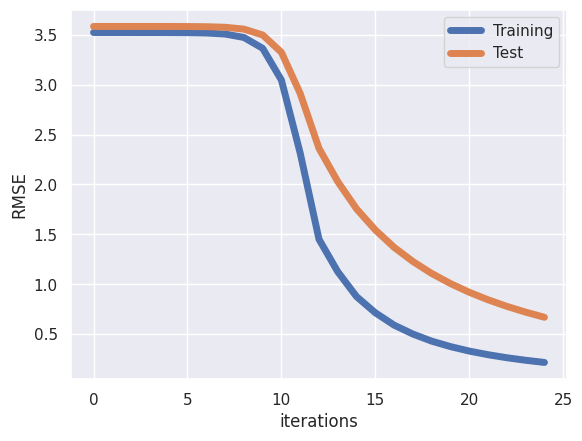

In [ ]:
latent_factors = [5, 10, 20]
regularizations = [0.001, 0.01, 0.1]
learning_rate = [1e-2, 1e-3, 1e-4]
iter_array = [25]

best_params = {}
best_params['n_factors'] = latent_factors[0]
best_params['reg'] = regularizations[0]
best_params['n_iter'] = iter_array[0]
best_params['learning_rate'] = learning_rate[0]
best_params['train_rmse'] = np.inf
best_params['test_rmse'] = np.inf
best_params['model'] = None

for fact, n_iter, reg, lr in itertools.product(
    latent_factors, iter_array, regularizations, learning_rate):
    print('Factors: {}'.format(fact))
    print('iterations: {}'.format(n_iter))
    print('regularization: {}'.format(reg))
    print('learning_rate: {}'.format(lr))

    method = 'gd'
    model_name = ''.join([
        method,
        '_fact_', str(fact),
        '_reg_', str(reg),
        '_iter_', str(n_iter),
        '_lr_', str(lr)])
    als_grid = ExplicitMF(
        train, method=method, n_factors=fact, n_iterations=n_iter, reg=reg, learning_rate=lr)
    start_time = time.time()
    als_grid.training(test)
    training_time = time.time() - start_time
    min_idx = np.argmin(als_grid.test_rmse)
    if als_grid.test_rmse[min_idx] >= best_params['test_rmse']:
        continue

    metrics = als_grid.get_all_metrics(test)
    results.append(
        [model_name] + list(dataclasses.astuple(metrics)) + [training_time])
    best_params['n_factors'] = fact
    best_params['reg'] = reg
    best_params['n_iter'] = n_iter
    best_params['learning_rate'] = lr
    best_params['train_rmse'] = als_grid.train_rmse[min_idx]
    best_params['test_rmse'] = als_grid.test_rmse[min_idx]
    best_params['model'] = als_grid
    print('New optimal hyperparameters')
    print(pd.Series(best_params))
    print('--- %s seconds ---' % (training_time))

best_gd_model = best_params['model']
plot_learning_curve(best_gd_model)


In [ ]:
results_pd = results_to_pd(results)
results_pd.dropna(inplace=True)

In [ ]:
results_pd.style.background_gradient(
    'RdYlGn_r', axis=0, subset=lower_better
).background_gradient('RdYlGn', axis=0, subset=higher_better)

,RMSE training,RMSE test,MRR k=5 test,MRR k=10 test,Mean NDCG k=5 test,Mean NDCG k=10 test,MAP k=5 test,MAP k=10 test,Training time
Model / Metric,,,,,,,,,
pop,2.945142,2.953382,0.024708,0.030475,0.314206,0.369220,0.023206,0.028557,6.243155
bias,2.736662,2.952546,0.024708,0.030475,0.313749,0.368491,0.023206,0.028557,3.472923
gd,0.371258,1.000717,0.041375,0.049384,0.190115,0.224997,0.041375,0.049012,181.397758
als,1.914690,2.556994,0.058625,0.076692,0.589683,0.601269,0.057432,0.068826,136.775790
als_fact_5_reg_0.001_iter_25,2.092618,2.672822,0.062372,0.076007,0.553577,0.563467,0.061577,0.070376,226.456078
als_fact_10_reg_0.001_iter_25,1.914747,2.557230,0.056186,0.074735,0.591119,0.601574,0.054993,0.067351,207.123170
als_fact_10_reg_0.1_iter_25,1.914774,2.556583,0.058872,0.075986,0.592586,0.601820,0.057414,0.068951,224.039754
als_fact_20_reg_0.001_iter_25,1.747101,2.527355,0.057370,0.077122,0.621030,0.632492,0.056354,0.068145,224.407036
gd_fact_5_reg_0.001_iter_25_lr_0.001,3.524107,3.585048,0.012354,0.016761,0.020277,0.031342,0.012089,0.016110,18.666824


####Quetions 4 (5 points)

Which are the best hyperparameters for the GD model?

Discuss your observations (overfitting, etc.)


Following an extension of the hyperparameter search for the GD model, we introduced the learning rate hyperparameter to the grid. In the table above, it becomes evident that the optimal results for the GD algorithm align with the default hyperparameters identified in question 1. However, a notable observation arises when considering the impact of the learning rate.

The default hyperparameters from question 1, without a specific learning rate, consistently deliver the best overall results. Introducing a low learning rate (0.001) into the grid reveals competitive performance in terms of RMSE. However, this success appears to be somewhat deceptive as other evaluation metrics exhibit less favorable outcomes.

The indication of good results for RMSE with a low learning rate (0.001) suggests a potential issue of overfitting.

####Question 5 (5 points)

Compare all models trained (popularity, bias, ALS, GD); Are there different models which are better when considering different metrics? Discuss the reasoning. Discuss your insights regarding the models performance (accuracy, time to train etc.). Describe possible tasks and their corresponding preferable model.

Upon analyzing the results from the table above, several insights can be drawn regarding the performance of different recommendation algorithms, including Popularity, Bias, ALS, and GD.

**Popularity and Bias**

Popularity and Bias models exhibit significantly shorter training times compared to GD and ALS. While their results metrics are reasonable, they do not achieve optimal results across the board. These models offer a quick and computationally efficient approach, but their simplicity may limit their ability to capture intricate user preferences and item relevance.

**GD**

The Gradient Descent (GD) model demonstrates less favorable results for most metrics, indicating suboptimal performance compared to other algorithms. Additionally, GD tends to cause overfitting in many instances, as reflected by its underperformance across various evaluation metrics. Moreover, the training time for GD is relatively high, making it less efficient compared to other algorithms.

**ALS**

The Alternating Least Squares (ALS) algorithm emerges as a strong performer, achieving the best results for most metrics, except RMSE. While ALS may not precisely learn the entire rating matrix, it excels in capturing the relevance of each item for users. The ALS algorithm demonstrates a good balance between accuracy and efficiency, making it a robust choice for collaborative filtering.

</br>

**Comparative Insights**

**Accuracy vs. Efficiency Trade-off:** ALS strikes a balance between accuracy and training time, making it a preferable choice when a good compromise is needed.

**Overfitting Concerns:** GD tends to cause overfitting, which may lead to less robust generalization. Careful consideration and possibly regularization methods are required to mitigate this issue.

####Question 6 (5 points bonus)

Suggest possible enhancements that could potentially improve your models (no need to implement).

**All Algorithms**

- Enrich the data, fill the rating matrix.

**GD**

 - We can leverage advanced gradient descent algorithms, such as the Adam optimizer, to enhance the optimization process. The Adam optimizer dynamically adjusts the learning rate during training, making it particularly effective in scenarios with varying gradients.

**GD and ALS**

 - Increasing the value of n_factors enhances the model's flexibility by introducing more parameters. This augmentation allows the model to capture more intricate patterns in the training data, thereby enabling it to better approximate the characteristics of the original matrix R.
- Use validation set, and choose the best tested model on the test set in all the iteration, and finally compare the models hyperparams performance - stop before over fitting

## Model explainability
In this section, you will try to qualitatively asses the results of your models



####Question 7 (5 points)

Select an item similarity method which you find best suitable for this dataset and implement it using numpy and pandas only.

In [ ]:
def adjusted_cosine_similarity(user_item_matrix, item_i, item_j):
    user_rating_by_item_i = user_item_matrix[:, item_i]
    user_rating_by_item_j = user_item_matrix[:, item_j]

    # Find the common users who have rated both items
    common_users = np.logical_and(user_rating_by_item_i != 0, user_rating_by_item_j != 0)

    if not np.any(common_users):
        return 0.0

    μ_i = np.mean(user_rating_by_item_i[common_users])
    μ_j = np.mean(user_rating_by_item_j[common_users])
    s_ui = user_rating_by_item_i - μ_i
    s_uj = user_rating_by_item_j - μ_j

    numerator = np.dot(s_ui, s_uj)
    denominator = np.linalg.norm(s_ui) * np.linalg.norm(s_uj)

    if denominator == 0:
        return 0.0
    else:
        return numerator / denominator

def similarity(model: ExplicitMF) -> np.ndarray:
    """Computes item-to-item similarity.

    Args:
        model: trained RS model.

    Returns:
        Similarity matrix.
    """
    R_tag = model.predict_all()
    num_items = R_tag.shape[1]
    similarity_matrix = np.zeros((num_items, num_items))

    for i in range(num_items):
        for j in range(i, num_items):
            similarity = adjusted_cosine_similarity(R_tag, i, j)
            similarity_matrix[i, j] = similarity
            similarity_matrix[j, i] = similarity

    return similarity_matrix


pop_sim = similarity(pop)
bias_sim = similarity(bias)
als_sim = similarity(best_als_model)
gd_sim = similarity(best_gd_model)

In [ ]:
def display_top_k_movies(similarity: np.ndarray, movie_idx: int, k: int = 5):
    """Prints most similar movies.

    Args:
        similarity: similarity matrix.
        movie_idx: movie index.
        k: number of similar movies to print.
    """
    movie_indices = np.argsort(similarity[movie_idx,:])[::-1]
    movie_titles = []
    # Start i at 1 to not grab the input movie.
    i = 1
    while i <= k:
        movie_titles.append(df_items['movie_title'][movie_indices[i]])
        i += 1
    print('Recommended movies: ', movie_titles)

def compare_recs(pop_similarity: np.ndarray, bias_similarity: np.ndarray,
                 als_similarity: np.ndarray, gd_similarity: np.ndarray,
                 movie_idx: int, k: int = 5):
    """Prints most similar movies in every model.

    Args:
        pop_similarity: similarity matrix for popularity model.
        bias_similarity: similarity matrix for bias model.
        als_similarity: similarity matrix for als model.
        gd_similarity: similarity matrix for gd model.
        movie_idx: movie index.
        k: number of similar movies to print.
    """
    print('Input movie: ', df_items['movie_title'][movie_idx])

    print('Popularity model recommendations:')
    display_top_k_movies(pop_similarity, movie_idx, k)

    print('Bias model recommendations:')
    display_top_k_movies(bias_similarity, movie_idx, k)

    print('GD model recommendations:')
    display_top_k_movies(gd_similarity, movie_idx, k)

    print('ALS model recommendations:')
    display_top_k_movies(als_similarity, movie_idx, k)


####Question 8 (5 points)

Compare between the recommendations of the various models.

Show the recommendations for three movies and discuss the quality of the results obtained by the different models.

In [ ]:
movie_idx = 1102 # Select a movie
k=5
compare_recs(pop_sim, bias_sim, als_sim, gd_sim, movie_idx, k)

Input movie:  Trust (1990)
Popularity model recommendations:
Recommended movies:  ['For the Moment (1994)', 'Chasing Amy (1997)', 'Gordy (1995)', 'Locusts, The (1997)', 'For Ever Mozart (1996)']
Bias model recommendations:
Recommended movies:  ['Aladdin and the King of Thieves (1996)', 'Operation Dumbo Drop (1995)', 'Something to Talk About (1995)', 'Trust (1990)', 'Mrs. Parker and the Vicious Circle (1994)']
GD model recommendations:
Recommended movies:  ['Treasure of the Sierra Madre, The (1948)', 'Deer Hunter, The (1978)', 'Philadelphia Story, The (1940)', 'Great Dictator, The (1940)', 'Harold and Maude (1971)']
ALS model recommendations:
Recommended movies:  ['Living in Oblivion (1995)', 'Naked (1993)', 'Amateur (1994)', 'Crumb (1994)', 'Three Colors: White (1994)']


**The movie: Trust (1990)**

The common between the movies are:

- most of the movies are drama, action, comedy or combination of them movies
- alot of the movies are directed by Hal Hartley

In [ ]:
movie_idx = 12 # Select a movie
k=5
compare_recs(pop_sim, bias_sim, als_sim, gd_sim, movie_idx, k)

Input movie:  Mighty Aphrodite (1995)
Popularity model recommendations:
Recommended movies:  ["She's the One (1996)", 'Four Weddings and a Funeral (1994)', 'Kolya (1996)', 'American Werewolf in London, An (1981)', "Things to Do in Denver when You're Dead (1995)"]
Bias model recommendations:
Recommended movies:  ['Secrets & Lies (1996)', 'Annie Hall (1977)', 'African Queen, The (1951)', 'Cool Hand Luke (1967)', 'Big Night (1996)']
GD model recommendations:
Recommended movies:  ["Ulee's Gold (1997)", "Eve's Bayou (1997)", 'Kolya (1996)', 'Lost Highway (1997)', 'Jackie Brown (1997)']
ALS model recommendations:
Recommended movies:  ['Big Night (1996)', 'Postino, Il (1994)', 'Secrets & Lies (1996)', 'Cold Comfort Farm (1995)', 'Lone Star (1996)']


**The movie: Mighty Aphrodite (1995)**

The common between the movie and the recommended movies are:

- most of the movies are comedy, romance or combination of them movies

In [ ]:
movie_idx = 132 # Select a movie
k=5
compare_recs(pop_sim, bias_sim, als_sim, gd_sim, movie_idx, k)

Input movie:  Gone with the Wind (1939)
Popularity model recommendations:
Recommended movies:  ['For the Moment (1994)', 'Chasing Amy (1997)', 'Gordy (1995)', 'Locusts, The (1997)', 'For Ever Mozart (1996)']
Bias model recommendations:
Recommended movies:  ['Face/Off (1997)', 'Dave (1993)', 'Mary Poppins (1964)', 'Evita (1996)', 'Fantasia (1940)']
GD model recommendations:
Recommended movies:  ['Roman Holiday (1953)', 'Secret of Roan Inish, The (1994)', 'It Happened One Night (1934)', 'Fish Called Wanda, A (1988)', 'Old Man and the Sea, The (1958)']
ALS model recommendations:
Recommended movies:  ['Wizard of Oz, The (1939)', "It's a Wonderful Life (1946)", 'My Fair Lady (1964)', 'African Queen, The (1951)', 'Christmas Carol, A (1938)']


**The movie: Gone with the Wind (1939)**

The common between the movie and the recommended movies are:

- most of the movies are drama, romance or combination of them movies

In summary,
the genre of the movies are similar, for some there are more details like actors, and directors.